### Distances 154 combined points - 6 class training

#### Environment preparation

In [1]:
# Montowanie Google Drive
from google.colab import drive
drive.mount('/content/drive')

COLAB_ROOT = '/content/drive/MyDrive/PainRecognitionProject/'
print(f"Dane będą wczytywane z: {COLAB_ROOT}")

Mounted at /content/drive
Dane będą wczytywane z: /content/drive/MyDrive/PainRecognitionProject/


In [2]:
import os

# Przejście do katalogu głównego
%cd /content

# Klonowanie repo
!rm -rf automatic-pain-recognition

print(f"Obecne położenie: {os.getcwd()}")

/content
Obecne położenie: /content


In [3]:
# Upewnij się, że nazwa użytkownika i repozytorium są poprawne
USERNAME = 'alicka33'
REPO_NAME = 'automatic-pain-recognition'

# Tworzenie poprawnego adresu URL (format: https://<TOKEN>@github.com/...)
REPO_URL = f"https://github.com/{USERNAME}/{REPO_NAME}.git"

print("Rozpoczynam klonowanie...")

# Klonowanie
!git clone {REPO_URL}

# Wejście do katalogu
%cd $REPO_NAME

Rozpoczynam klonowanie...
Cloning into 'automatic-pain-recognition'...
remote: Enumerating objects: 241, done.
remote: Counting objects: 100% (241/241), done.
remote: Compressing objects: 100% (189/189), done.
remote: Total 241 (delta 108), reused 179 (delta 48), pack-reused 0 (from 0)
Receiving objects: 100% (241/241), 10.86 MiB | 16.67 MiB/s, done.
Resolving deltas: 100% (108/108), done.
/content/automatic-pain-recognition


In [4]:
# Instalacja wymaganych bibliotek
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 13.2 MB/s eta 0:00:00
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0


In [5]:
import sys
import os

# Dodaj katalog główny projektu do ścieżki systemowej
sys.path.append(os.getcwd())
print(f"Dodano do ścieżki Pythona: {os.getcwd()}")

Dodano do ścieżki Pythona: /content/automatic-pain-recognition


#### Distances 154 combined points - 6 class training

In [6]:
import os
import numpy as np
import pandas as pd
import shutil

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from training_utils.preprocessed_dataset import PreprocessedDataset
from training_utils.train import Trainer
from training_utils.evaluate import Evaluator
from models.Bi_LSTM import SequenceModel

#### Hiperparameters

In [7]:
MAX_SEQUENCE_LENGTH = 37
NUM_FEATURES = 154
NUM_CLASSES = 6
HIDDEN_SIZE = 128
NUM_LAYERS = 2
NUM_EPOCHS = 200
BATCH_SIZE = 16
LEARNING_RATE = 0.00005
DROPOUT_PROB = 0.4
WEIGHT_DECAY = 0.005
SCHEDULER_FACTOR = 0.8

#### Data preparation

In [8]:
COLAB_ROOT = '/content/drive/MyDrive/PainRecognitionProject/'
PROCESSED_DATA_DIR = os.path.join(COLAB_ROOT, 'data/RAVDESS_processed_478_xyz_frontalized/')
MODEL_SAVE_DIR = os.path.join(COLAB_ROOT, 'models/')
LOCAL_PROCESSED_DATA_ROOT = '/content/temp_data/'

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
print("Kopiowanie danych z Google Drive do lokalnej pamięci Colab (RAM)...")
if os.path.exists(LOCAL_PROCESSED_DATA_ROOT):
    shutil.rmtree(LOCAL_PROCESSED_DATA_ROOT)
try:
    shutil.copytree(PROCESSED_DATA_DIR, LOCAL_PROCESSED_DATA_ROOT)
    print("✅ Kopiowanie zakończone pomyślnie. Czas trwania: (sprawdź zegar)")
    CURRENT_DATA_DIR = LOCAL_PROCESSED_DATA_ROOT

except Exception as e:
    print(f"❌ Błąd kopiowania danych (sprawdź, czy dane są zamontowane): {e}")
    print("Używam danych bezpośrednio z Drive (może się zawiesić).")
    CURRENT_DATA_DIR = PROCESSED_DATA_DIR

Kopiowanie danych z Google Drive do lokalnej pamięci Colab (RAM)...
✅ Kopiowanie zakończone pomyślnie. Czas trwania: (sprawdź zegar)


In [10]:
best_154_landmarks = np.load('/content/drive/MyDrive/PainRecognitionProject/data/combined_selected_points_emotions.npy')

In [11]:
train_dataset = PreprocessedDataset(
    'train',
    processed_data_dir=CURRENT_DATA_DIR,
    indices=best_154_landmarks,
    compute_euclidean=True,
    center_point_index=2,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    selected_labels=[2, 3, 4, 5, 6, 8],
    label_map={2: 0, 3: 1, 4: 2, 5: 3, 6: 4, 8: 5},
)

val_dataset = PreprocessedDataset(
    'val',
    processed_data_dir=CURRENT_DATA_DIR,
    indices=best_154_landmarks,
    compute_euclidean=True,
    center_point_index=2,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    selected_labels=[2, 3, 4, 5, 6, 8],
    label_map={2: 0, 3: 1, 4: 2, 5: 3, 6: 4, 8: 5},
)

test_dataset = PreprocessedDataset(
    'test',
    processed_data_dir=CURRENT_DATA_DIR,
    indices=best_154_landmarks,
    compute_euclidean=True,
    center_point_index=2,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    selected_labels=[2, 3, 4, 5, 6, 8],
    label_map={2: 0, 3: 1, 4: 2, 5: 3, 6: 4, 8: 5},
)

In [12]:
def preview_single(dataset, idx=0, timesteps_to_show=3, features_to_show=8):
    x, y = dataset[idx]
    print(f"\nSingle sample idx={idx} from split={dataset.dataset_name}")
    print(f"x shape: {tuple(x.shape)}, y: {y}")
    print(np.round(x[:timesteps_to_show, :features_to_show], 4))

preview_single(train_dataset, 0)
preview_single(val_dataset, 0)
preview_single(test_dataset, 0)


Single sample idx=0 from split=train
x shape: (37, 154), y: 0
tensor([[0.0000, 0.1144, 0.1634, 0.3016, 0.3973, 0.4532, 0.1317, 0.1736],
        [0.0000, 0.1166, 0.1651, 0.2994, 0.3941, 0.4516, 0.1305, 0.1725],
        [0.0000, 0.1176, 0.1661, 0.2988, 0.3955, 0.4537, 0.1278, 0.1702]])

Single sample idx=0 from split=val
x shape: (37, 154), y: 0
tensor([[0.0000, 0.1165, 0.1638, 0.2942, 0.3949, 0.4512, 0.1199, 0.1994],
        [0.0000, 0.1154, 0.1632, 0.2941, 0.4017, 0.4612, 0.1226, 0.1965],
        [0.0000, 0.1144, 0.1620, 0.2925, 0.3961, 0.4548, 0.1134, 0.1923]])

Single sample idx=0 from split=test
x shape: (37, 154), y: 0
tensor([[0.0000, 0.1116, 0.1613, 0.3001, 0.4110, 0.4719, 0.1351, 0.2000],
        [0.0000, 0.1127, 0.1621, 0.2991, 0.4090, 0.4696, 0.1349, 0.1977],
        [0.0000, 0.1128, 0.1618, 0.2977, 0.4069, 0.4673, 0.1374, 0.2016]])


In [13]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
for X, y in train_loader:
    print(X.shape, y.shape)  # (B, T_max, num_features)
    break

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
for X, y in val_loader:
    print(X.shape, y.shape)  # (B, T_max, num_features)
    break

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
for X, y in test_loader:
    print(X.shape, y.shape)  # (B, T_max, num_features)
    break

torch.Size([16, 37, 154]) torch.Size([16])
torch.Size([16, 37, 154]) torch.Size([16])
torch.Size([16, 37, 154]) torch.Size([16])


#### Model preparation

In [14]:
model = SequenceModel(NUM_FEATURES, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES, DROPOUT_PROB).to(DEVICE)

#### Training

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=SCHEDULER_FACTOR,
    patience=10,
    min_lr=1e-7
)

model_name = 'testing_new_code_emotions_154_distances_6_classes.pt'
model_filepath = os.path.join(MODEL_SAVE_DIR, model_name)

In [16]:
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    device=DEVICE,
    model_save_path=model_filepath,
    num_epochs=NUM_EPOCHS,
    monitor='val_acc',  # or 'val_loss'
    minimize_monitor=False,
    save_best_only=True
)

In [17]:
trainer.print_training_config()



🚀 TRAINING CONFIGURATION

--- Model Architecture ---
  Model Type            : SequenceModel
  Input Features        : 154
  Hidden Size           : 128
  Num Layers            : 2
  Bidirectional         : True
  Dropout (LSTM)        : 0.4
  Num Parameters        : 687622

--- Optimizer & Regularization ---
  Optimizer             : AdamW
  Learning Rate (LR)    : 5e-05
  Weight Decay (L2)     : 0.005

--- Training Flow ---
  Batch Size            : 16
  Num Epochs            : 200
  Device                : cuda



In [18]:
final_model_path, best_model_path, history = trainer.fit()
print(f"Final model saved to: {final_model_path}")
if best_model_path:
    print(f"Best model saved to: {best_model_path}")


Starting training for 200 epochs on cuda
Saved best model to /content/drive/MyDrive/PainRecognitionProject/models/best_testing_new_code_emotions_154_distances_6_classes.pt (metric=0.1645)
Epoch 1/200 | Time 4.77s | Train loss 1.7944 | Train acc 0.1556 | Val loss 1.7921 | Val acc 0.1645
Epoch 2/200 | Time 2.81s | Train loss 1.7910 | Train acc 0.1790 | Val loss 1.7910 | Val acc 0.1645
Epoch 3/200 | Time 2.84s | Train loss 1.7893 | Train acc 0.1868 | Val loss 1.7901 | Val acc 0.1645
Saved best model to /content/drive/MyDrive/PainRecognitionProject/models/best_testing_new_code_emotions_154_distances_6_classes.pt (metric=0.1828)
Epoch 4/200 | Time 2.79s | Train loss 1.7908 | Train acc 0.1868 | Val loss 1.7884 | Val acc 0.1828
Saved best model to /content/drive/MyDrive/PainRecognitionProject/models/best_testing_new_code_emotions_154_distances_6_classes.pt (metric=0.2141)
Epoch 5/200 | Time 3.17s | Train loss 1.7861 | Train acc 0.1960 | Val loss 1.7845 | Val acc 0.2141
Saved best model to /co

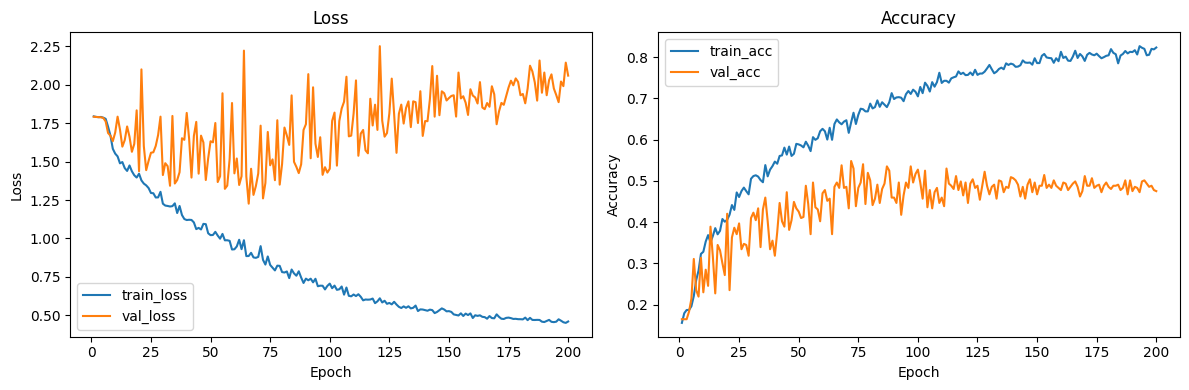

In [19]:
trainer.plot_history()

#### Evaluate

In [20]:
model.load_state_dict(torch.load(best_model_path, map_location=DEVICE), strict=False)

<All keys matched successfully>

In [21]:
evaluator = Evaluator(model, test_loader, device=DEVICE, model_name=model_name, num_classes=NUM_CLASSES)

In [22]:
loss, acc, labels, preds = evaluator.evaluate_epoch()


WYNIKI OCENY DLA MODELU: testing_new_code_emotions_154_distances_6_classes.pt
Test Loss: 1.4928
Test Accuracy: 0.4844

--- Szczegółowy Raport Klasyfikacji ---
              precision    recall  f1-score   support

     Klasa 0       0.60      0.50      0.55        64
     Klasa 1       1.00      0.47      0.64        64
     Klasa 2       0.36      0.81      0.50        64
     Klasa 3       0.69      0.66      0.67        64
     Klasa 4       0.33      0.38      0.35        64
     Klasa 5       0.27      0.09      0.14        64

    accuracy                           0.48       384
   macro avg       0.54      0.48      0.47       384
weighted avg       0.54      0.48      0.47       384

Confusion matrix:
 [[32  0 28  2  0  2]
 [ 8 30 14  0  4  8]
 [ 0  0 52  8  4  0]
 [ 0  0  8 42 12  2]
 [12  0 20  4 24  4]
 [ 1  0 24  5 28  6]]
